In [74]:
from pyscf.gto import Mole
mol = Mole(atom='O 0 0 0; O 0 0 1.1; H 2 0 2.1; H 0 0 3.1;O 0 0 0; O 0 0 1.1; H 2 0 2.1; Cu 0 0 3.1', basis='sto3g').build()
mol.nao
mol._bas

from pyscf.gto.mole import _parse_default_basis
_parse_default_basis(mol.basis, mol.elements)

gto.format_basis({'O^2':'sto-3g', 'H^2': '3-21g'})

from pyscf.data.elements import ELEMENTS, ELEMENTS_PROTON, \
        _rm_digit, charge, _symbol, _std_symbol, _atom_symbol, is_ghost_atom, \
        _std_symbol_without_ghost

_atom_symbol('O')

'O'

In [75]:
from pyscf import gto
import numpy as np
import scipy.linalg
from scipy.linalg import fractional_matrix_power
from typing import Tuple
np.set_printoptions(precision=7, linewidth=120, suppress=True)


class Molecule:
    def __init__(self):
        # Project 03 existed
        self.atom_charges = NotImplemented  # type: np.ndarray
        self.atom_coords = NotImplemented  # type: np.ndarray
        self.natm = NotImplemented  # type: int
        self.mol = NotImplemented  # type: gto.Mole
        self.nao = NotImplemented  # type: int
        self.charge = 0  # type: int
        self.nocc = NotImplemented  # type: int
        # Project 04 added
        self.mo_coeff = NotImplemented  # type: np.ndarray
        self.mo_energy = NotImplemented  # type: np.ndarray
        self.eri_ao = NotImplemented  # type: np.ndarray
        self.eri_mo = NotImplemented  # type: np.ndarray
        self.energy_rhf = NotImplemented  # type: np.ndarray
        self.energy_corr = NotImplemented  # type: np.ndarray

    def construct_from_dat_file(self, file_path: str):
        # Same to Project 01
        with open(file_path, "r") as f:
            dat = np.array([line.split() for line in f.readlines()][1:])
            self.atom_charges = np.array(dat[:, 0], dtype=float).astype(int)
            self.atom_coords = np.array(dat[:, 1:4], dtype=float)
            self.natm = self.atom_charges.shape[0]
    def obtain_mol_instance(self, basis: str, verbose=0):
        # Same to Project 03
        mol = gto.Mole()
        mol.unit = "Bohr"
        mol.atom = "\n".join([("{:3d} " + " ".join(["{:25.18f}"] * 3)).format(chg, *coord) for chg, coord in zip(self.atom_charges, self.atom_coords)])
        mol.basis = basis
        mol.charge = self.charge
        mol.spin = 0
        mol.verbose = verbose
        self.mol = mol.build()

sol_mole = Molecule()
sol_mole.construct_from_dat_file("input/h2o/STO-3G/geom.dat")
sol_mole.obtain_mol_instance(basis="STO-3G")
sol_mole.mol.build()
print(sol_mole.mol._bas)

mol = sol_mole.mol
ANG_OF, NCTR_OF = 1, 3

"""
`[[atom-id, angular-momentum, num-primitive-GTO, num-contracted-GTO, 0, ptr-of-exps, ptr-of-contract-coeff, 0], [...]]` each element represents one shell
"""

print(((mol._bas[:,ANG_OF]*2+1) * mol._bas[:,NCTR_OF]).sum())


[[ 0  0  3  1  0 32 35  0]
 [ 0  0  3  1  0 38 41  0]
 [ 0  1  3  1  0 44 47  0]
 [ 1  0  3  1  0 50 53  0]
 [ 2  0  3  1  0 50 53  0]]
7


In [23]:
(mol._bas[:,ANG_OF]*2+1)

array([1, 1, 3, 1, 1], dtype=int32)

In [76]:
# from pyscf.pbc import gto, scf
from pyscf.tools import chgcar
import numpy
# cell = gto.M(atom='H 0 0 0; H 0 0 1', a=numpy.eye(3)*3)
from pyscf import gto, scf

mol = gto.Mole()
mol.build(
    atom = [['O',(0.000000000000,  -0.143225816552,   0.000000000000)],
            ['H', (1.638036840407,   1.136548822547 , -0.000000000000)],
            ['H', (-1.638036840407,   1.136548822547 , 0.000000000000)]],  
    basis = 'sto-3g',
    charge = 0,
    spin = 0,
)
mf = scf.RHF(mol).run()
chgcar.density(mol, 'h2.CHGCAR', mf.make_rdm1())
chgcar.orbital(mol, 'h2_mo1.CHGCAR', mf.mo_coeff[:,0])
mol.basis

converged SCF energy = -74.3627486850124

WARN: Molecular system is found. FFT-grid is not available for Molecule. Lattice (in Bohr)
[[12.190882   0.         0.       ]
 [ 0.         8.4184236  0.       ]
 [ 0.         0.         6.       ]]
and FFT grids (60, 60, 60) are applied.


WARN: Molecular system is found. FFT-grid is not available for Molecule. Lattice (in Bohr)
[[12.190882   0.         0.       ]
 [ 0.         8.4184236  0.       ]
 [ 0.         0.         6.       ]]
and FFT grids (60, 60, 60) are applied.



'sto-3g'

In [6]:
from pyscf import lib
from pyscf import gto, scf
from pyscf.gto.moleintor import make_loc
import ctypes
import numpy
import warnings
from pyscf import __config__
libcgto = lib.load_library('libcgto')

BLKSIZE = 56  # must be equal to lib/gto/grid_ao_drv.h
NBINS = 100
CUTOFF = getattr(__config__, 'eval_gto_cutoff', 1e-15)

_GTO_EVAL_FUNCTIONS = {
    # Functiona name        : (comp-for-scalar, comp-for-spinor)
    'GTOval'                : (1, 1 ),
    'GTOval_ip'             : (3, 3 ),
    'GTOval_ig'             : (3, 3 ),
    'GTOval_ipig'           : (9, 9 ),
    'GTOval_deriv0'         : (1, 1 ),
    'GTOval_deriv1'         : (4, 4 ),
    'GTOval_deriv2'         : (10,10),
    'GTOval_deriv3'         : (20,20),
    'GTOval_deriv4'         : (35,35),
    'GTOval_sp'             : (4, 1 ),
    'GTOval_ipsp'           : (12,3 ),
    'GTOval_ipipsp'         : (36,9 ),
}


def _get_intor_and_comp(mol, eval_name, comp=None):
    if not ('_sph' in eval_name or '_cart' in eval_name or
            '_spinor' in eval_name):
        if mol.cart:
            eval_name = eval_name + '_cart'
        else:
            eval_name = eval_name + '_sph'

    if comp is None:
        if '_spinor' in eval_name:
            fname = eval_name.replace('_spinor', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[1]
        else:
            fname = eval_name.replace('_sph', '').replace('_cart', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[0]
        if comp is None:
            warnings.warn('Function %s not found.  Set its comp to 1' % eval_name)
            comp = 1
    return eval_name, comp

mol = gto.M(atom='O 0 -0.143225816552 0; H 1.638036840407 1.136548822547 1; H -1.638036840407 1.136548822547 0', basis='sto-3g')
mf = scf.RHF(mol).run()
coords = numpy.random.random((100,3))

eval_name, comp = _get_intor_and_comp(mol, "GTOval", 1)

print(eval_name, comp)
ngrids = 200
blksize = min(8000, ngrids)
rho = numpy.empty(ngrids)
dm = mf.make_rdm1()
for ip0, ip1 in lib.prange(0, ngrids, blksize):
    print(ip0, ip1)
    ao = mol.eval_gto('GTOval', coords[ip0:ip1])
    print(ao.shape, dm.shape)
    rho[ip0:ip1] = lib.einsum('pi,ij,pj->p', ao, dm, ao)
# print(rho)

dm

converged SCF energy = -74.3163053217111
GTOval_sph 1
0 200
(100, 7) (7, 7)


ValueError: could not broadcast input array from shape (100,) into shape (200,)

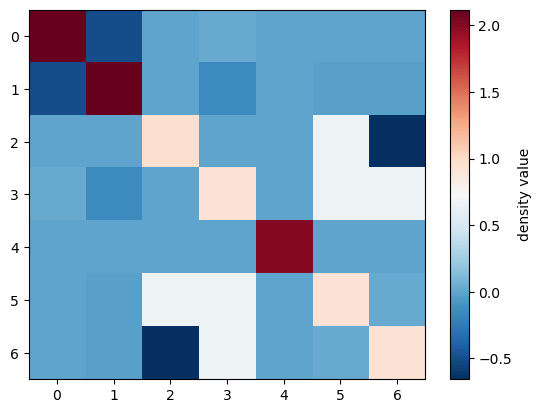

In [79]:
import matplotlib.pyplot as plt
import numpy as np 
vals = dm
heatmap_data = np.zeros((len(vals), len(vals[0])))
for i in range(len(vals)):
    for j in range(len(vals[0])):
        heatmap_data[i,j] = vals[i][j]

cmap = plt.cm.RdBu_r
plt.imshow(heatmap_data, cmap=cmap, aspect='auto') # auto adjusted colorbar range to [min, max]
plt.colorbar(label='density value')
plt.show()

In [69]:
dm.shape

(7, 7)

In [53]:
lib.einsum('pi,ij,pj->p', ao, dm, ao)

ValueError: Size of label 'i' for operand 1 (7) does not match previous terms (24).